In [5]:
import torch
from torchvision import transforms
import torch.utils.data as data
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from models import *
from data_loader import get_loader

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])


def caption_list_gen(caption,batch_size):
    caption_list=[]
    for i in range(len(caption[0])):
        new_caption=[]
        for j in range(len(caption)):
            new_caption.append(caption[j][i])
        caption_list.append(new_caption)
    return caption_list


def load_model(model_path='model_13epochs_sumboth.tar',map_location='cpu'):
    image_model = VGG19(pretrained=True)
    caption_model = LSTMBranch()
    checkpoint = torch.load(model_path, map_location)
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    image_model.load_state_dict(checkpoint['image_model'])
    caption_model.load_state_dict(checkpoint['caption_model'])
    print ("Loaded checkpoint '{}' (epoch {})".format(model_path,checkpoint['epoch']))
    return image_model, caption_model


def gen_matchmap(image_model, caption_model, image_tensor, caption_tensor):
    image_op = image_model(image_tensor)
    caption_op = caption_model(caption_tensor)

    n_imgs = image_op.size(0)
    matchmap_list = []

    for i in range(n_imgs):
        matchmap = matchmap_generate(image_op[i],caption_op[i])
        mm = matchmap.detach().numpy()
        matchmap_list.append(mm)

    return matchmap_list

def get_data(batch_size, fetch_mode='retrieval'):
    data_loader_val = get_loader(transform=transform,
                                  mode='val',
                                  batch_size=1,
                                  vocab_from_file=True,
                                  fetch_mode='retrieval',
                                  data_mode='imagecaption',
                                  disp_mode='imgcapretrieval',
                                  num_workers=0,
                                  test_size=1000)
    imgindices = data_loader_val.dataset.get_imgindices()
    new_sampler_img = data.sampler.SubsetRandomSampler(indices=imgindices)
    data_loader_val.batch_sampler.sampler=new_sampler_img
    
    for batch in data_loader_val:
        image_tensor,ground_truth_captions,caption_glove_list,captions = batch[0],batch[1],batch[2],batch[3]
        break
    print ("Sanity Check ---> Size of the selected test Image Tensor",image_tensor.shape)
    print ("Sanity Check ---> Size of the selected test Glove-Caption Tensor",caption_glove_list.shape)
    
    return image_tensor,caption_glove_list,captions,ground_truth_captions

def get_output(image_tensor,image_model,caption_glove_tensor,caption_model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_model = image_model.to(device)
    caption_model = caption_model.to(device)
    image_model.eval()
    caption_model.eval()
    image_ip_val = image_tensor.to(device)
    all_caption_output_val=[]
    caption_glove_ip_val = caption_glove_tensor.to(device)
    caption_output_val = caption_model(caption_glove_ip_val)
    image_output_val = image_model(image_ip_val)
    print ("Sanity Check ---> Size of the output tensor from LSTM ",caption_output_val.shape)
    print ("Sanity Check ---> Size of the output tensor from Image Model ",image_output_val.shape)
    return image_output_val, caption_output_val

def get_sim_mat(image_output,caption_glove_tensor_output,score_type):
    sim_mat=[]
    for captiontensor in caption_glove_tensor_output:
        captiontensor = torch.unsqueeze(captiontensor,dim=0)
        sim_val = compute_matchmap_similarity_matrix(image_output,captiontensor,score_type)
        sim_mat.append(sim_val)
    return sim_mat

Loaded checkpoint 'model_13epochs_sumboth.tar' (epoch 13)
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
Obtaining lengths of all the test dataset captions..
Sanity Check ---> Size of the selected test Image Tensor torch.Size([1, 3, 224, 224])
Sanity Check ---> Size of the selected test Glove-Caption Tensor torch.Size([1, 4955, 22, 300])
Sanity Check ---> Size of the output tensor from LSTM  torch.Size([4955, 22, 1024])
Sanity Check ---> Size of the output tensor from Image Model  torch.Size([1, 1024, 14, 14])
**************************************************
The Ground Truth Captions are:
1 :  A woman riding water skis on top of a lake.
2 :  a woman wearing a life jacket as she goes  waterskiing 
3 :  a woman surfing on very strong waves in the ocean
4 :  A woman water skiing with a life jacket near boats.
5 :  a person that is being pulled that is on skiies
***************************************

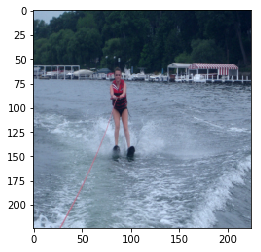

In [8]:
image_model, caption_model = load_model()
batch_size = 64
score_type = 'Avg_Both'
image_tensor,caption_glove_list,captions,ground_truth_captions = get_data(batch_size)
new_caption = torch.squeeze(caption_glove_list,dim=0)

img = torch.squeeze(image_tensor,0)
img = img.permute(1,2,0)
color_img = img.numpy()
color_img = (color_img - np.amin(color_img)) / np.ptp(color_img)
plt.imshow(color_img)

new_caption = torch.squeeze(caption_glove_list,dim=0)

image_output, caption_glove_tensor_output = get_output(image_tensor,image_model,new_caption,caption_model)
sim_mat = get_sim_mat(image_output,caption_glove_tensor_output,score_type)
sim_mat = torch.Tensor(sim_mat)
#C2I_scores, C2I_ind = sim_mat.topk(1,0)
I2C_scores, I2C_ind = sim_mat.topk(5,0)

print ("**************************************************")
print ("The Ground Truth Captions are:")
k=1
for gtcaption in ground_truth_captions:
    print (k,": ",gtcaption[0])
    k=k+1
print ("**************************************************")

print ("**************************************************")
k=1
print ("The predicted captions are:")
for captid in I2C_ind:
    print (k,": ",captions[captid][0])
    k=k+1
print ("**************************************************")